<a href="https://colab.research.google.com/github/Theophine/Time-series-forecasting-/blob/main/Forecasting_future_commute_in_Norway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#business case

A bike rental start-up, Acme Bikes, want to forecast the number of people using their bikes to and from work. In addition, the dataset is augmented with historical rainfall and temperature data. We are asked to provide some insights into the dataset and provide a forecast model to estimate future commutes at any given time horizon. We are also asked to provide some indication of validity in the form of statistical tests. 



In [ ]:
# import all libraries and dependencies for dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# import all libraries and dependencies for data visualization
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
sns.set(style='darkgrid')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bike_data.csv to bike_data.csv


In [ ]:
import pandas as pd
import io
bike = pd.read_csv(io.BytesIO(uploaded['bike_data.csv']), parse_dates =True, index_col = 'Date')

#Data investigation

In [ ]:
bike.head()

,Volume,Rain,Temp,Unnamed: 4,Unnamed: 5,Unnamed: 6
Date,,,,,,
2016-11-17,933,9.0,2.1,NaN,NaN,NaN
2016-11-18,1197,6.7,3.9,NaN,NaN,NaN
2016-11-19,243,5.4,2.0,NaN,NaN,NaN
2016-11-20,234,3.9,2.8,NaN,NaN,NaN
2016-11-21,2148,7.3,2.8,NaN,NaN,NaN


In [ ]:
df_bike = bike[['Volume', 'Rain', 'Temp']]

In [ ]:
df_bike.head()

,Volume,Rain,Temp
Date,,,
2016-11-17,933,9.0,2.1
2016-11-18,1197,6.7,3.9
2016-11-19,243,5.4,2.0
2016-11-20,234,3.9,2.8
2016-11-21,2148,7.3,2.8


In [ ]:
df_bike.shape

(1273, 3)

In [ ]:
df_bike.describe()

,Volume,Rain,Temp
count,1273.000000,1273.000000,1273.000000
mean,2609.344855,1.945640,6.783975
std,1968.623825,4.505151,7.726084
min,63.000000,0.000000,-11.400000
25%,1185.000000,0.000000,0.700000
50%,2073.000000,0.000000,5.500000
75%,3801.000000,1.400000,13.400000
max,8679.000000,39.500000,25.900000


In [ ]:
df_bike['Volume'].mean(), df_bike['Volume'].max(), df_bike['Volume'].min()

(2609.3448546739983, 8679, 63)

##Forecasting steps 

Before we start working we make a brief work breakdown as follows:

Visually inspect the data and control for missing data and outliers

If needed, transform the data

Make a first prediction model without any tuning and validate the model.


Tune and test the model with the addition of special events and dates


Tune and test the model with rainfall and temperature as additional regressors.


Tuning hyperparameters

##Import the prophet forecasting packages

In [ ]:
from sklearn import preprocessing    #for scaling 
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from scipy.stats import boxcox
from scipy.special import inv_boxcox

## prophet constraints 

Prophet expects columns to have specific names, ds for the temporal part (date index) and y for the value part (the univariate time series to be modelled). 

In [ ]:
df_bike.columns = ['y', 'Rain', 'Temp']

You have to rename the index from 'date' to 'ds'

In [ ]:
df_bike.index.name = 'ds'

In [ ]:
#check the code
df_bike.head()

,y,Rain,Temp
ds,,,
2016-11-17,933,9.0,2.1
2016-11-18,1197,6.7,3.9
2016-11-19,243,5.4,2.0
2016-11-20,234,3.9,2.8
2016-11-21,2148,7.3,2.8


##plot the timeseries to view its trajectory 

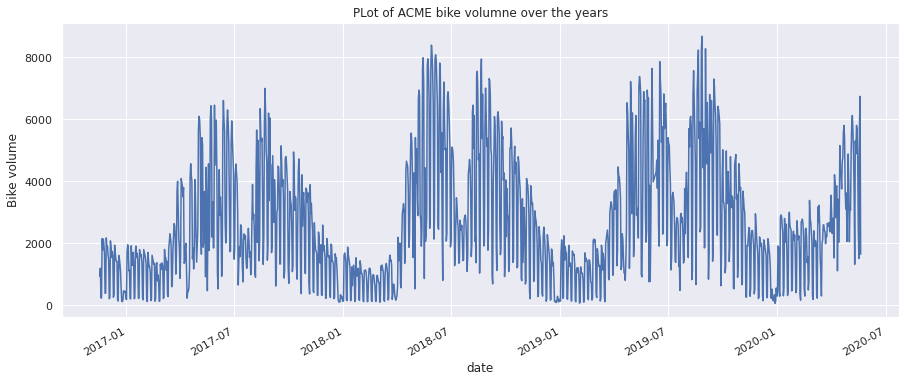

In [ ]:
df_bike['y'].plot(figsize = (15, 6))
plt.title('PLot of ACME bike volumne over the years');
plt.xlabel('date')
plt.ylabel('Bike volume')
plt.show();

observation from plot 

From the plot, it shows that the data has seasonality which is obvious. But it is diffcult to say if the data is trending upwards as it moves into the future. 
Furthermore, the plot looks 'additive' rather than 'multiplicative'. 

##check for missing values and outliers 

In [ ]:
df_bike.isna().sum()

y       0
Rain    0
Temp    0
dtype: int64

We need to look deeper into the data set to ensure that there are not date ranges missing 

In [ ]:
df_bike.index.min(), df_bike.index.max()

(Timestamp('2016-11-17 00:00:00'), Timestamp('2020-05-20 00:00:00'))

In [ ]:
pd.date_range(start = df_bike.index.min(), end = df_bike.index.max())

DatetimeIndex(['2016-11-17', '2016-11-18', '2016-11-19', '2016-11-20',
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26',
               ...
               '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18',
               '2020-05-19', '2020-05-20'],
              dtype='datetime64[ns]', length=1281, freq='D')

In [ ]:
df_bike.shape[0]

1273

Our dataset has 1273 observations instead of 1281 observations. Therefore, there are 8 missing date ranges

Below I will investigate the missing date ranges 

In [ ]:
df_bike_missing = pd.date_range(start = df_bike.index.min(), end = df_bike.index.max()).difference(df_bike.index)

In [ ]:
bike_missing = pd.DataFrame(df_bike_missing, columns = ['Date']).set_index('Date')
bike_missing['days'] = bike_missing.index.weekday
bike_missing['day_name'] = bike_missing['days'].map({0: 'monday', 1:'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'Friday', 5: 'Saturday',6: 'sunday'})
bike_missing

,days,day_name
Date,,
2017-10-16,0,monday
2019-01-14,0,monday
2019-06-07,4,Friday
2019-06-08,5,Saturday
2019-06-09,6,sunday
2019-06-10,0,monday
2019-08-14,2,wednesday
2019-08-15,3,thursday


In [ ]:
bike_missing['day_name'].value_counts(dropna = False)

monday       3
wednesday    1
Friday       1
sunday       1
Saturday     1
thursday     1
Name: day_name, dtype: int64

in the original dataset, let us view the days in which bikes were traded

In [ ]:
df_bike['days'] = df_bike.index.weekday
df_bike['day_name'] = df_bike['days'].map({0: 'monday', 1:'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'Friday', 5: 'Saturday',6: 'sunday'})
df_bike['day_name'].value_counts(dropna = False)

tuesday      183
thursday     182
wednesday    182
sunday       182
Friday       182
Saturday     182
monday       180
Name: day_name, dtype: int64

Observation:

based on the above, it shows that bikes were traded on every single day of the week. 

therefore, we need to expand the  time series to include the missing values and interpolate them 

In [ ]:
df_bike = df_bike.asfreq('d')
df_bike.shape[0]

1281

check for missing values and then fix them 

In [ ]:
df_bike.isna().sum()

y           8
Rain        8
Temp        8
days        8
day_name    8
dtype: int64

In [ ]:
df_bike['y'].interpolate(inplace = True)
df_bike['Rain'].interpolate(inplace = True)
df_bike['Temp'].interpolate(inplace = True)

In [ ]:
#test our code 
df_bike_new = df_bike[['y', 'Rain', 'Temp']]
df_bike_new.isna().sum()

y       0
Rain    0
Temp    0
dtype: int64

##checking out for outliers 

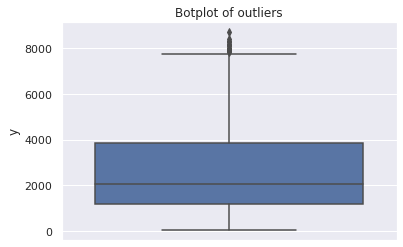

In [ ]:
sns.boxplot(y = 'y', data = df_bike)
plt.title('Botplot of outliers')
plt.show();

Below we shall do a little deeper investigation into the outliers

In [ ]:
print('The value at the 95 percentiel is {:.2f}'.format(np.percentile(df_bike_new['y'], 95)))
print('The value at the 75 percentiel is {:.2f}'.format(np.percentile(df_bike_new['y'], 75)))
print('The value at the 25 percentiel is {:.2f}'.format(np.percentile(df_bike_new['y'], 25)))

The value at the 95 percentiel is 6573.00
The value at the 75 percentiel is 3831.00
The value at the 25 percentiel is 1191.00


In [ ]:
IQR = np.percentile(df_bike_new['y'], 75) - np.percentile(df_bike_new['y'], 25)
whisker_value = (IQR * 1.5) + np.percentile(df_bike_new['y'], 75)
whisker_value

7791.0

In [ ]:
len(df_bike_new[df_bike_new['y'] > whisker_value])

14

For one, the outliers are very few compared to the len of the overall observations. secondly the outliers do not distort the pattern in the observation. 
Therefore, chances are that I will work with the outlier values present in the data without removing or replacing them. 

##checking for variability. 

For this, we plot a normal distribution of the data. if the data is not normally distributed around the mean, then we perform a boxcox transformation. 

In [ ]:
import statsmodels.api as sm

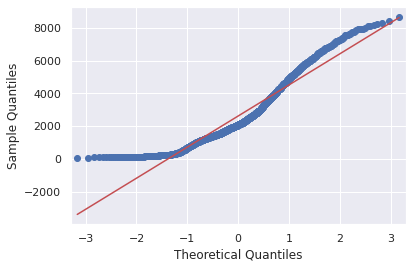

In [ ]:
sm.qqplot(df_bike_new['y'], line = 'r')
plt.show();

Based on the above normal distribution plot, the data is not normally distributed. 


##plot of orignal vs boxcox transformed time series

In [ ]:
boxcox(df_bike_new['y'])[0]

array([36.11627364, 40.16786922, 20.03307186, ..., 77.62676263,
       82.74634685, 45.98412223])

In [ ]:
np.log(df_bike_new['y'])

ds
2016-11-17    6.838405
2016-11-18    7.087574
2016-11-19    5.493061
2016-11-20    5.455321
2016-11-21    7.672292
                ...   
2020-05-16    7.817625
2020-05-17    7.319202
2020-05-18    8.661294
2020-05-19    8.815964
2020-05-20    7.406711
Freq: D, Name: y, Length: 1281, dtype: float64

In [ ]:
df_bike_new.head()

,y,Rain,Temp
ds,,,
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8


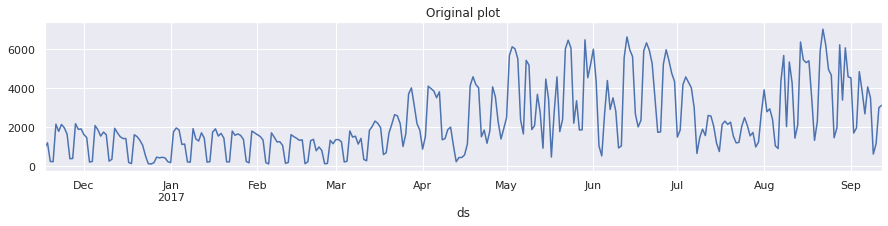

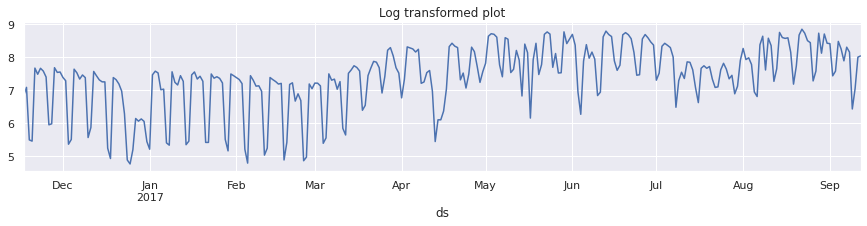

In [ ]:
plt.subplot(2,1,1)
df_bike_new['y'][:300].plot(figsize = (15, 6))
plt.title('Original plot')
plt.show();

plt.subplot(2, 1, 2)
np.log(df_bike_new['y'])[:300].plot(figsize = (15, 6))
plt.title('Log transformed plot')
plt.show();


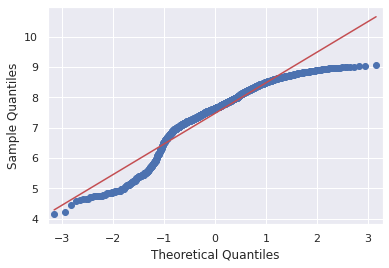

In [ ]:
sm.qqplot(np.log(df_bike_new['y']), line = 'r')
plt.show();

##Applying boxcox transformation

In [ ]:
from scipy.stats import boxcox

In [ ]:
df_bike_new['y'], lam = boxcox(df_bike_new['y'])
print('Lambda is:', lam)

Lambda is: 0.4004489572463605


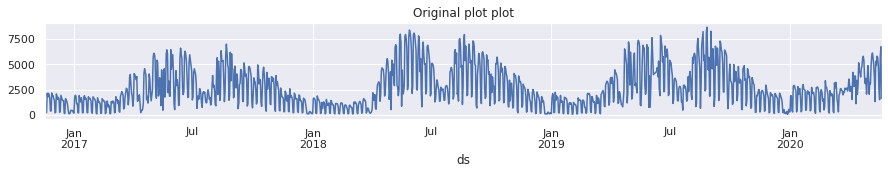

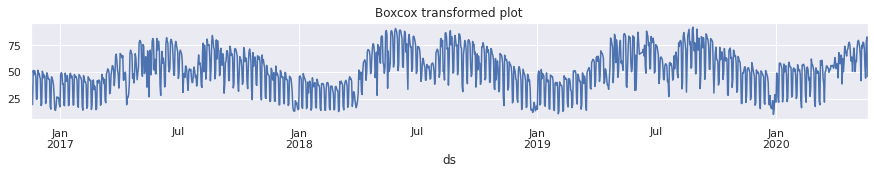

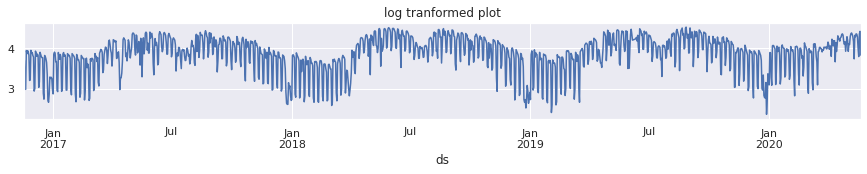

In [ ]:
#we can plot the boxcox transformed model and compare it to a log transformed model
plt.subplot(3,1,1)
df_bike['y'].plot(figsize = (15, 6))
plt.title('Original plot plot')
plt.show();

plt.subplot(3,1,2)
df_bike_new['y'].plot(figsize = (15, 6))
plt.title('Boxcox transformed plot')
plt.show();

plt.subplot(3, 1, 3)
np.log(df_bike_new['y']).plot(figsize = (15, 6))
plt.title('log tranformed plot')
plt.show();


NOTE: boxcox and log transforamtion are same. the only difference is the lambda value and the range of the returned values for the log tranformation and the boxcox transformation. 

also, as can be seen in the diagrame, the variability has reduced. 

##Create a  plot of the rain and temperature data

In [ ]:


df_bike_log = np.log(df_bike[['y', 'Rain', 'Temp']])

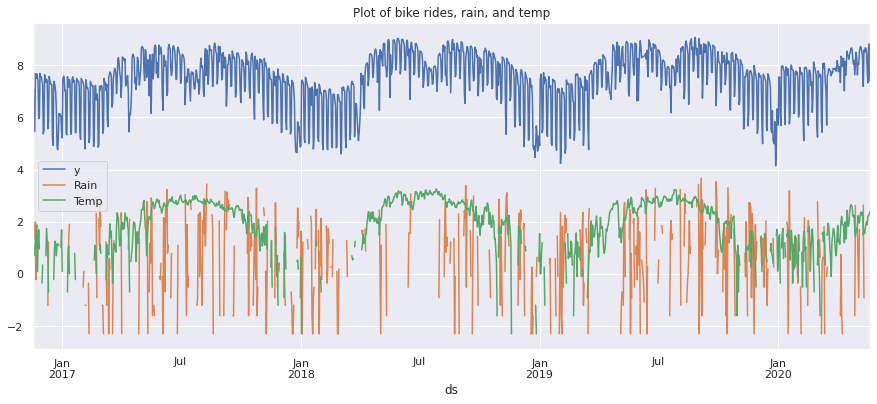

In [ ]:
df_bike_log.plot(figsize = (15, 6))
plt.title('Plot of bike rides, rain, and temp')
plt.show();

Our working data will be df_forecast_data

In [ ]:
df_forecast = df_bike_new.copy()

In [ ]:
df_forecast_data = df_forecast[['y']]
df_forecast_data.reset_index(inplace = True)

Observations: 

Bike rides is highly correlated with the Temperature. Well, logically, more people would prefer to ride during sunny bright days than during cold cloudy days. 

From the plot, it is quite difficult to tell the correlation between rain and the number of commute. But it looks fairly correlation and thus, it is possible for rain to play a pivotal role in predicting the commute volume. 


#Forecast

In [ ]:
#instantiating our model 
prophet = Prophet(seasonality_mode= 'multiplicative')

#fit the model 
prophet_model = prophet.fit(df_forecast_data)

#create future dataframe for the forecast
future_period = prophet_model.make_future_dataframe(periods = 180, freq = 'D')
commute_forecast = prophet_model.predict(future_period)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##Plotting the forecast

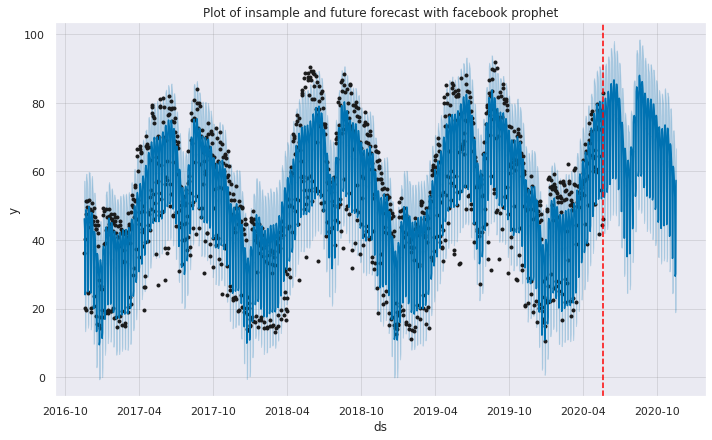

In [ ]:
prophet_model.plot(commute_forecast)
plt.title('Plot of insample and future forecast with facebook prophet')
plt.axvline(df_forecast_data['ds'].max(), linestyle = '--', color = 'red')
plt.show()

NOTE: The plot after the red dotted vertical line show the future forecast. 

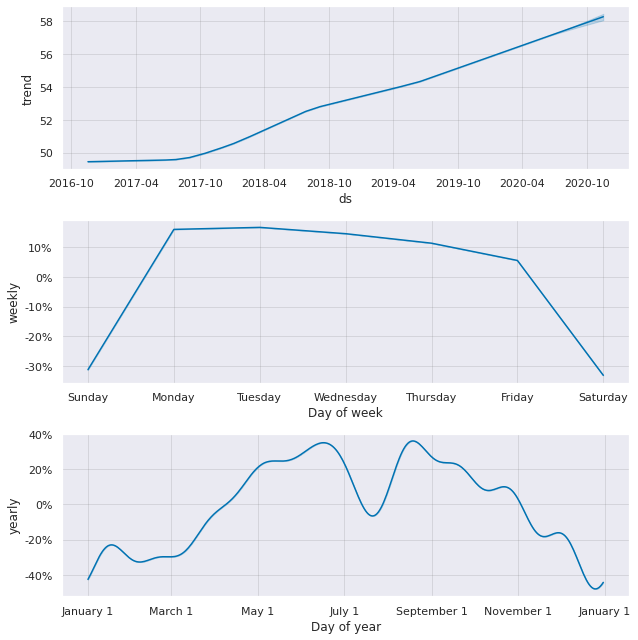

In [ ]:
#show the plot components
prophet_model.plot_components(commute_forecast)
plt.show();

Observation

We can see that we have a clear positive trend and that Monday and Tuesday are the days when most people commute. We also see a strong yearly seasonality.

##Plotting change points 

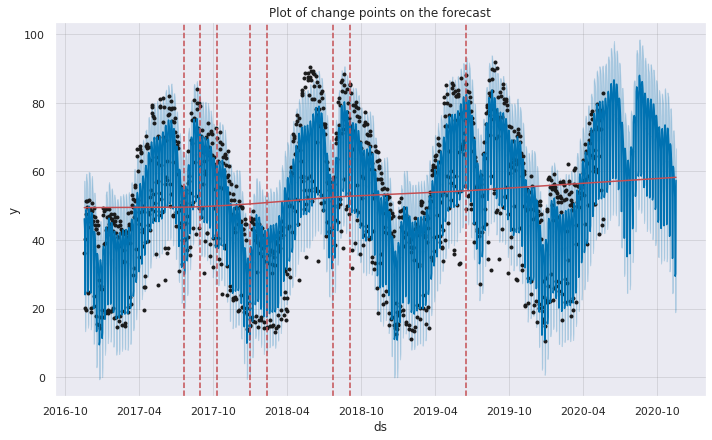

In [ ]:
fig = prophet_model.plot(commute_forecast)
add_changepoints_to_plot(fig.gca(), prophet_model, commute_forecast)
plt.title('Plot of change points on the forecast')
plt.show()

##Cross-Validation - validating our result 

In order for us to find out how our model performs and know if we are making progress we need some form of validation. 

Facebook provides some in-built cross validation function for us. 

In [ ]:
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

In [ ]:
df_cv = cross_validation(prophet_model, initial= '730 days', period = '31 days', horizon = '365 days')
df_cv

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-18,45.404946,36.005355,55.276451,47.028123,2018-12-17
1,2018-12-19,43.588887,33.627688,53.154702,41.301367,2018-12-17
2,2018-12-20,40.490321,29.932793,50.319834,42.550875,2018-12-17
3,2018-12-21,37.017957,26.541589,46.788482,34.684642,2018-12-17
4,2018-12-22,14.214890,5.088960,23.718624,15.307835,2018-12-17
...,...,...,...,...,...,...
2185,2020-05-16,53.802053,42.965350,63.882261,54.655634,2019-05-21
2186,2020-05-17,54.956741,44.755122,64.774870,44.314633,2019-05-21
2187,2020-05-18,82.767587,72.586445,93.053615,77.626763,2019-05-21
2188,2020-05-19,83.940934,73.740006,94.316659,82.746347,2019-05-21


##computing the performance metric

In [ ]:
df_performance = performance_metrics(df_cv)
df_performance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,93.152828,9.651571,6.771950,0.191365,0.094658,0.799087
1,38 days,93.005061,9.643913,6.779216,0.191427,0.101328,0.801370
2,39 days,91.821168,9.582336,6.713029,0.188861,0.099634,0.810502
3,40 days,101.587515,10.079063,6.896050,0.194711,0.101247,0.815068
4,41 days,102.327636,10.115712,6.960262,0.197291,0.101805,0.812785


In [ ]:
df_performance.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
324,361 days,96.122299,9.804198,7.842856,0.193691,0.132475,0.703196
325,362 days,95.537667,9.774337,7.783348,0.191525,0.131547,0.705479
326,363 days,93.112117,9.649462,7.666277,0.189348,0.129027,0.716895
327,364 days,91.920108,9.587497,7.558831,0.185364,0.126279,0.726027
328,365 days,98.675332,9.933546,7.660293,0.185424,0.125485,0.728311


In [ ]:
df_performance.shape

(329, 7)

##plot the performance metric

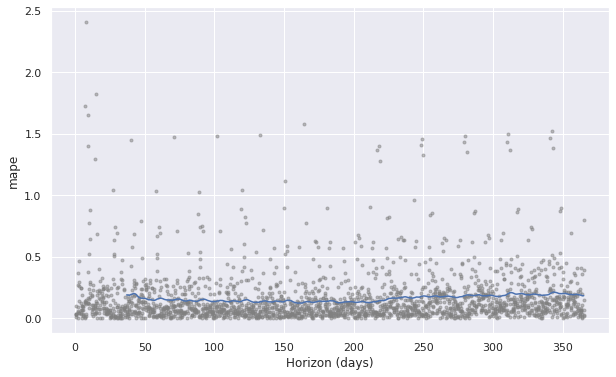

In [ ]:
plot_cross_validation_metric(df_cv, metric ='mape')
plt.show();

From the above, we can see that the errors is not exceedingly bad but there is a gradual increase as the forecast progresses into the future. 

##comparing validation results

In [ ]:
df_performance.mean()

horizon     201 days 00:00:00
mse                   85.5584
rmse                   9.2266
mae                   6.97628
mape                 0.162404
mdape                0.100342
coverage             0.784722
dtype: object

#Improving our forecast

##Adding holidays and special events

In [ ]:
#instantiate prophet
prophet_new = Prophet(seasonality_mode= 'multiplicative')

In [ ]:
#add the country name 
prophet_new.add_country_holidays(country_name= 'NO')

prophet_model_new = prophet_new.fit(df_forecast_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#after fitting the model with the country name inputted, you can then view the holidays associated with that country 
prophet_model_new.train_holiday_names

0                    Søndag
1           Første påskedag
2           Arbeidernes dag
3           Første pinsedag
4            Første juledag
5         Første nyttårsdag
6              Grunnlovsdag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object

In [ ]:
#Forecast using the holiday effects included
future_period_new =  prophet.make_future_dataframe(periods= 180, freq = 'D')
commute_forecast_new = prophet_model_new.predict(future_period_new)

In [ ]:
commute_forecast_new.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Andre juledag,Andre juledag_lower,Andre juledag_upper,Andre pinsedag,Andre pinsedag_lower,Andre pinsedag_upper,Andre påskedag,Andre påskedag_lower,Andre påskedag_upper,Arbeidernes dag,Arbeidernes dag_lower,Arbeidernes dag_upper,Første juledag,Første juledag_lower,Første juledag_upper,Første nyttårsdag,Første nyttårsdag_lower,Første nyttårsdag_upper,Første pinsedag,Første pinsedag_lower,Første pinsedag_upper,Første påskedag,Første påskedag_lower,Første påskedag_upper,Grunnlovsdag,Grunnlovsdag_lower,Grunnlovsdag_upper,Kristi himmelfartsdag,Kristi himmelfartsdag_lower,Kristi himmelfartsdag_upper,Langfredag,Langfredag_lower,Langfredag_upper,Skjærtorsdag,Skjærtorsdag_lower,Skjærtorsdag_upper,Søndag,Søndag_lower,Søndag_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1456,2020-11-12,59.483996,48.734958,66.724507,59.266205,59.718432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.036978,-0.036978,-0.036978,0.107353,0.107353,0.107353,-0.144331,-0.144331,-0.144331,0.0,0.0,0.0,57.284399
1457,2020-11-13,59.491255,43.198759,61.452052,59.271644,59.729050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.111610,-0.111610,-0.111610,0.042136,0.042136,0.042136,-0.153745,-0.153745,-0.153745,0.0,0.0,0.0,52.851463
1458,2020-11-14,59.498514,19.494827,37.824531,59.277082,59.735470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.512352,-0.512352,-0.512352,-0.350469,-0.350469,-0.350469,-0.161883,-0.161883,-0.161883,0.0,0.0,0.0,29.014350
1459,2020-11-15,59.505773,21.097414,39.171638,59.282464,59.744715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.10488,-0.10488,-0.10488,-0.10488,-0.10488,-0.10488,-0.493017,-0.493017,-0.493017,-0.219431,-0.219431,-0.219431,-0.168706,-0.168706,-0.168706,0.0,0.0,0.0,30.168399
1460,2020-11-16,59.513032,48.636452,67.321510,59.286696,59.753961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.023770,-0.023770,-0.023770,0.150444,0.150444,0.150444,-0.174215,-0.174215,-0.174215,0.0,0.0,0.0,58.098388


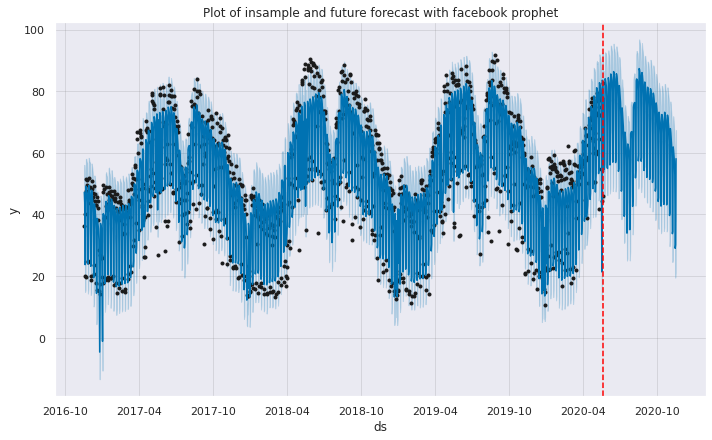

In [ ]:
prophet_model_new.plot(commute_forecast_new)
plt.title('Plot of insample and future forecast with facebook prophet')
plt.axvline(df_forecast_data['ds'].max(), linestyle = '--', color = 'red')
plt.show()

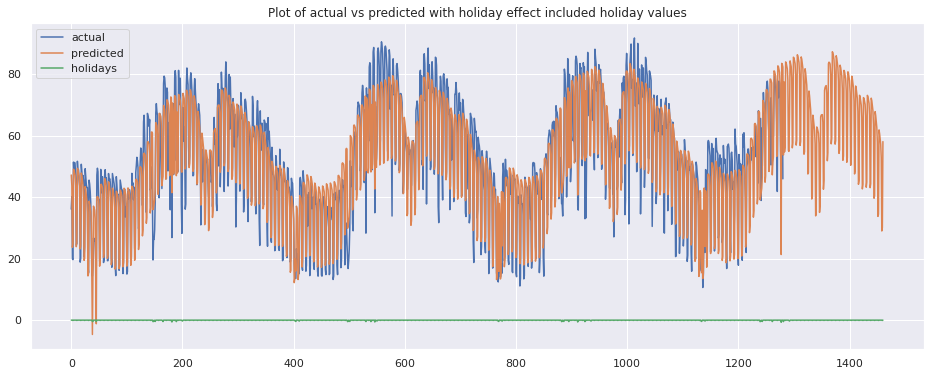

In [ ]:
#plot the predicted and actual data
plt.figure(figsize = (16, 6))
plt.plot(df_forecast_data['y'])
plt.plot(commute_forecast_new['yhat'])
plt.plot(commute_forecast_new.index, commute_forecast_new.holidays)
plt.legend(labels = ['actual', 'predicted', 'holidays'])
plt.title('Plot of actual vs predicted with holiday effect included holiday values')
plt.show();

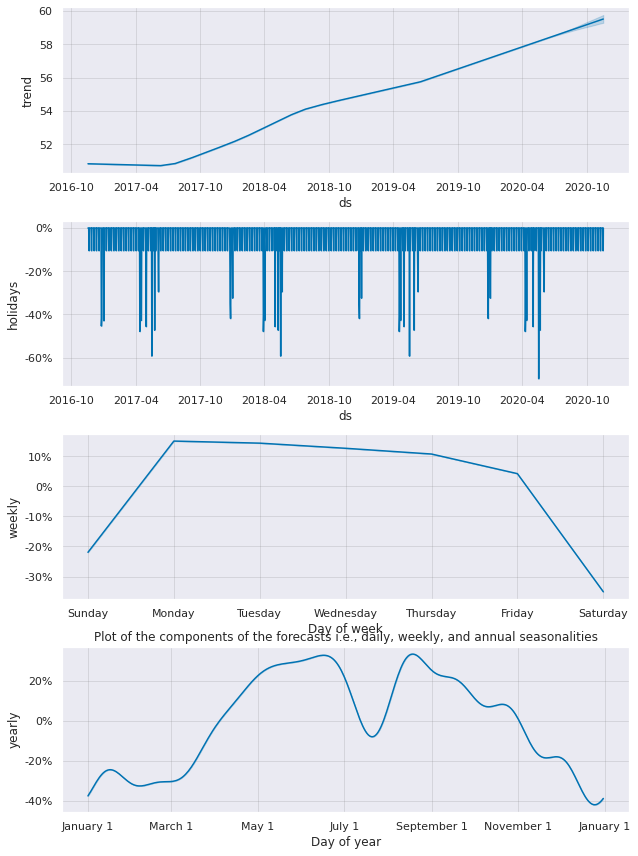

In [ ]:
prophet_model_new.plot_components(commute_forecast_new)
plt.title('Plot of the components of the forecasts i.e., daily, weekly, and annual seasonalities')
plt.show()

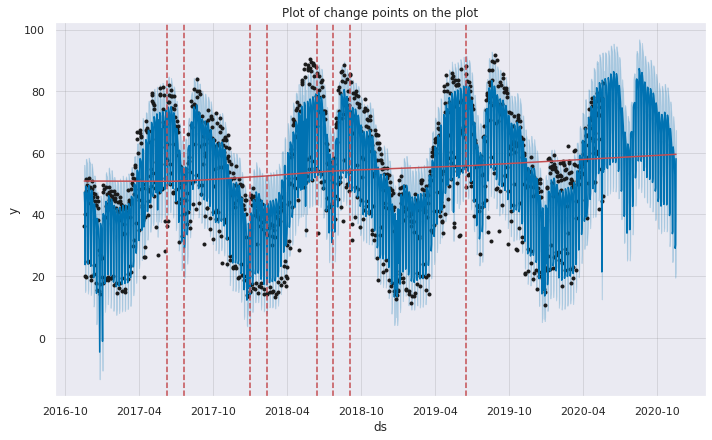

In [ ]:
fig = prophet_model_new.plot(commute_forecast_new)
add_changepoints_to_plot(fig.gca(), prophet_model_new, commute_forecast_new)
plt.title('Plot of change points on the plot')
plt.show();

In [ ]:
#Perform cross validation 
df_cv_new = cross_validation(prophet_model_new, initial= '730 days', period = '31 days', horizon = '365 days')
df_cv_new

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-18,46.861413,38.770840,54.916073,47.028123,2018-12-17
1,2018-12-19,45.095824,37.172456,53.203729,41.301367,2018-12-17
2,2018-12-20,43.318845,35.118369,51.017051,42.550875,2018-12-17
3,2018-12-21,39.061760,31.267028,47.606721,34.684642,2018-12-17
4,2018-12-22,15.757010,7.367286,23.308421,15.307835,2018-12-17
...,...,...,...,...,...,...
2185,2020-05-16,55.875918,47.383496,64.972128,54.655634,2019-05-21
2186,2020-05-17,11.928134,3.304694,19.546962,44.314633,2019-05-21
2187,2020-05-18,85.843301,76.657641,94.071108,77.626763,2019-05-21
2188,2020-05-19,86.167833,77.313663,95.029770,82.746347,2019-05-21


In [ ]:
df_performance_new =  performance_metrics(df_cv_new)
df_performance_new

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,68.730146,8.290365,5.829161,0.161789,0.091872,0.794521
1,38 days,68.860994,8.298252,5.869503,0.162472,0.093208,0.796804
2,39 days,67.614470,8.222802,5.811322,0.160174,0.091736,0.805936
3,40 days,70.318148,8.385592,5.884717,0.162834,0.090093,0.808219
4,41 days,71.319876,8.445110,5.951913,0.165249,0.091736,0.803653
...,...,...,...,...,...,...,...
324,361 days,108.213218,10.402558,8.106157,0.189173,0.144617,0.591324
325,362 days,109.039930,10.442219,8.077778,0.188294,0.141682,0.600457
326,363 days,106.423442,10.316174,7.964873,0.186466,0.140528,0.611872
327,364 days,104.944996,10.244267,7.888018,0.183116,0.138316,0.621005


##plot of the cross validation metric of the forecast with holiday effect

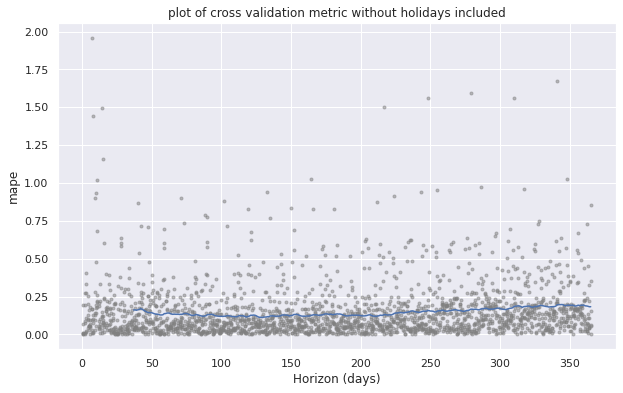

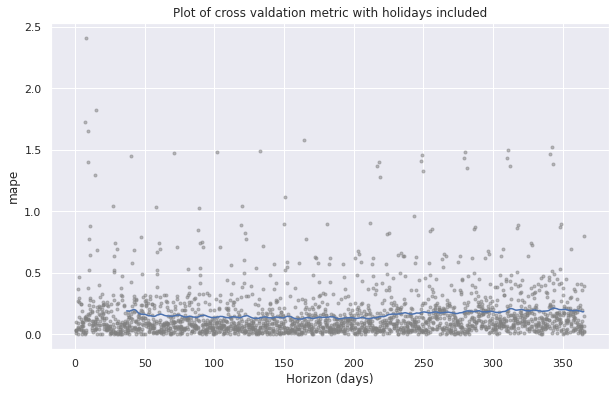

In [ ]:
plot_cross_validation_metric(df_cv_new, metric= 'mape')
plt.title('plot of cross validation metric without holidays included')
plt.show();


plot_cross_validation_metric(df_cv, metric= 'mape')
plt.title('Plot of cross valdation metric with holidays included')
plt.show();

##Error comparison - from the two evaluation metrics below, the mape has reduced but not so significantly. this is because holidays has been accounted for. 

In [ ]:
df_performance.mean()

horizon     201 days 00:00:00
mse                   85.5584
rmse                   9.2266
mae                   6.97628
mape                 0.162404
mdape                0.100342
coverage             0.784722
dtype: object

In [ ]:
df_performance_new.mean()

horizon     201 days 00:00:00
mse                   74.6246
rmse                  8.60674
mae                   6.56239
mape                 0.146944
mdape               0.0985393
coverage               0.7155
dtype: object

##Manually adding holidays to improve our model

In [ ]:
ascensionday = pd.DataFrame({
  'holiday': 'AscensionDay',
  'ds': pd.to_datetime(['2019-05-30']),
  'lower_window': -1,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 1,
})

holidays = pd.concat((ascensionday, christmas))

In [ ]:
holidays

,holiday,ds,lower_window,upper_window
0,AscensionDay,2019-05-30,-1,1
0,Christmas,2017-12-24,-1,1
1,Christmas,2018-12-24,-1,1
2,Christmas,2019-12-24,-1,1
3,Christmas,2020-12-24,-1,1


##Rebuild your model

In [ ]:
#instantiate prophet
prophet_new_holiday = Prophet(seasonality_mode= 'multiplicative', holidays = holidays)

In [ ]:
prophet_new_holiday.add_country_holidays(country_name= 'NO')

#fit the model
prophet_model_hol = prophet_new_holiday.fit(df_forecast_data)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_new_hol_future = prophet_model_hol.make_future_dataframe(periods=180, freq='D')
prophet_new_forecast = prophet_model_hol.predict(prophet_new_hol_future)

##visualize the actual vs predicted value

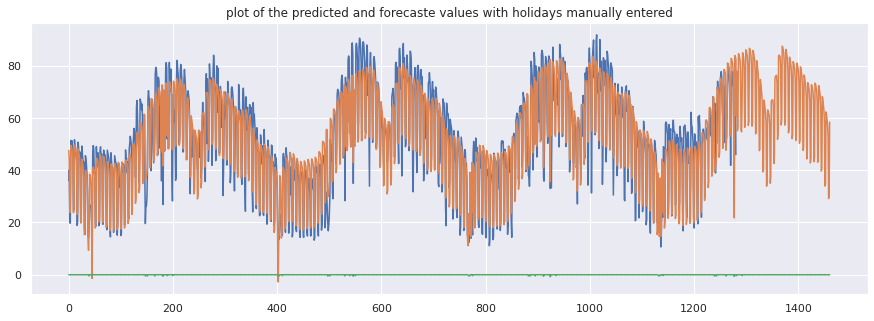

In [ ]:
plt.figure(figsize= (15, 5))
plt.plot(df_forecast_data['y'])
plt.plot(prophet_new_forecast['yhat'])
plt.plot(prophet_new_forecast.holidays)
plt.title('plot of the predicted and forecaste values with holidays manually entered')
plt.show();

##check out the performance metric

In [ ]:
df_cv_hol = cross_validation(prophet_model_hol, initial= '730 days', period = '31 days', horizon = '365 days')
df_cv_hol

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-18,46.345277,37.455704,53.806045,47.028123,2018-12-17
1,2018-12-19,44.582930,36.514212,52.213553,41.301367,2018-12-17
2,2018-12-20,42.841682,34.710223,50.865589,42.550875,2018-12-17
3,2018-12-21,38.590524,29.722451,46.349612,34.684642,2018-12-17
4,2018-12-22,15.412413,7.088584,22.875470,15.307835,2018-12-17
...,...,...,...,...,...,...
2185,2020-05-16,55.878170,47.023307,64.058177,54.655634,2019-05-21
2186,2020-05-17,11.789301,3.631571,19.640428,44.314633,2019-05-21
2187,2020-05-18,86.082349,77.312527,94.600489,77.626763,2019-05-21
2188,2020-05-19,86.282575,77.667953,95.147691,82.746347,2019-05-21


In [ ]:
df_performance_hol = performance_metrics(df_cv_hol)

##Plot of the validation metric once again

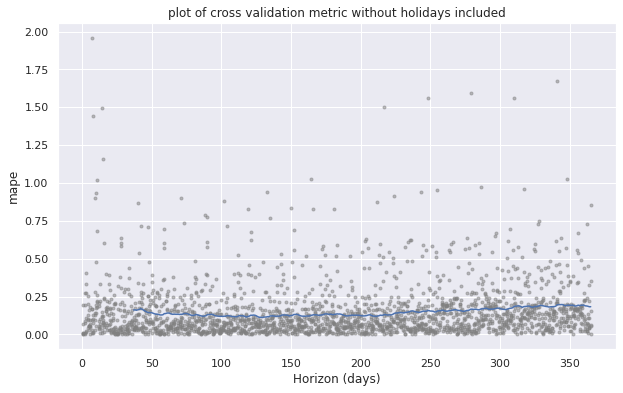

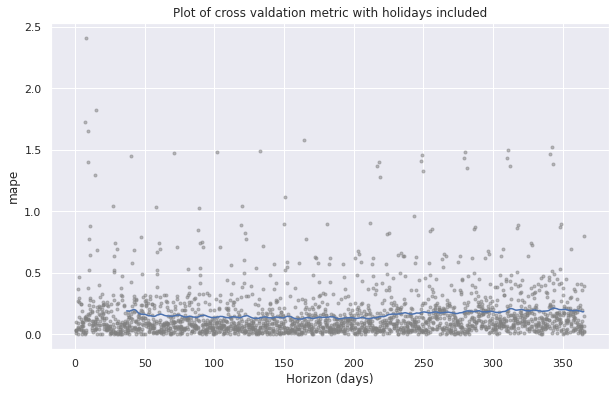

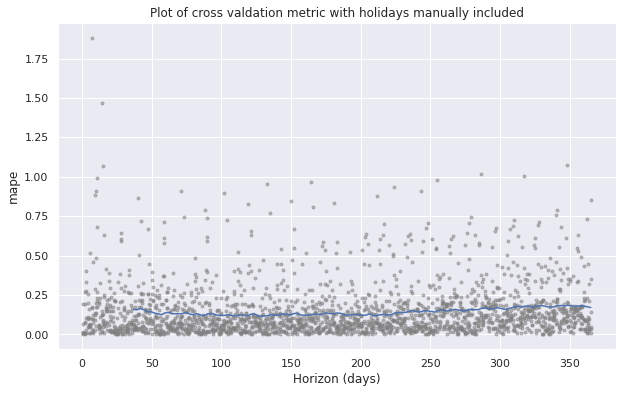

In [ ]:
plot_cross_validation_metric(df_cv_new, metric= 'mape')
plt.title('plot of cross validation metric without holidays included')
plt.show();


plot_cross_validation_metric(df_cv, metric= 'mape')
plt.title('Plot of cross valdation metric with holidays included')
plt.show();

plot_cross_validation_metric(df_cv_hol, metric= 'mape')
plt.title('Plot of cross valdation metric with holidays manually included')
plt.show();

In [ ]:
df_performance_hol.mean()

horizon     201 days 00:00:00
mse                   72.7785
rmse                  8.50233
mae                   6.48453
mape                 0.143879
mdape               0.0962107
coverage             0.719372
dtype: object

In [ ]:
df_performance_new.mean()

horizon     201 days 00:00:00
mse                   74.6246
rmse                  8.60674
mae                   6.56239
mape                 0.146944
mdape               0.0985393
coverage               0.7155
dtype: object

##Observation. There is improvement in our model by manually correcting the holidays that were not predicted properly.

Remember, the lower the mean and median absolute error, the better our model is

In [ ]:
prophet_reg = Prophet(seasonality_mode= 'multiplicative', holidays = holidays)

prophet_reg.add_country_holidays(country_name = 'NO')

prophet_reg.add_regressor('Rain')
prophet_reg.add_regressor('Temp')


In [ ]:
#merge the 'rain' and 'temp' columns into the dataframe
df_reg_data = df_forecast_data.merge(df_bike_new, on = ['ds', 'y'])

In [ ]:
#fit the prophet model with the regressors 
prophet_reg_model = prophet_reg.fit(df_reg_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_reg = prophet_reg_model.make_future_dataframe(periods = 1460, freq = 'D')
future_reg = future_reg.merge(df_reg_data, on = 'ds')

In [ ]:
future_reg.tail()

,ds,y,Rain,Temp
1276,2020-05-16,54.655634,0.0,6.6
1277,2020-05-17,44.314633,0.0,9.1
1278,2020-05-18,77.626763,0.0,9.3
1279,2020-05-19,82.746347,0.0,9.7
1280,2020-05-20,45.984122,0.0,10.8


In [ ]:
prophet_reg_pred = prophet_reg_model.predict(future_reg)
prophet_reg_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Andre juledag,Andre juledag_lower,Andre juledag_upper,Andre pinsedag,Andre pinsedag_lower,Andre pinsedag_upper,Andre påskedag,Andre påskedag_lower,Andre påskedag_upper,Arbeidernes dag,Arbeidernes dag_lower,Arbeidernes dag_upper,AscensionDay,AscensionDay_lower,AscensionDay_upper,Christmas,Christmas_lower,Christmas_upper,Første juledag,Første juledag_lower,Første juledag_upper,Første nyttårsdag,Første nyttårsdag_lower,Første nyttårsdag_upper,Første pinsedag,Første pinsedag_lower,Første pinsedag_upper,Første påskedag,Første påskedag_lower,Første påskedag_upper,Grunnlovsdag,Grunnlovsdag_lower,Grunnlovsdag_upper,Kristi himmelfartsdag,Kristi himmelfartsdag_lower,Kristi himmelfartsdag_upper,Langfredag,Langfredag_lower,Langfredag_upper,Rain,Rain_lower,Rain_upper,Skjærtorsdag,Skjærtorsdag_lower,Skjærtorsdag_upper,Søndag,Søndag_lower,Søndag_upper,Temp,Temp_lower,Temp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1276,2020-05-16,57.517742,40.941013,58.050511,57.517742,57.517742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014558,0.014558,0.014558,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.003579,-0.003579,-0.003579,0.010980,0.010980,0.010980,0.000000,0.000000,0.000000,-0.128848,-0.128848,-0.128848,-0.356183,-0.356183,-0.356183,0.216355,0.216355,0.216355,0.0,0.0,0.0,50.106671
1277,2020-05-17,57.524758,11.890051,28.081683,57.524758,57.524758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.590077,-0.590077,-0.590077,0.0,0.0,0.0,0.0,0.0,0.0,0.014558,0.014558,0.014558,0.0,0.0,0.0,-0.101832,-0.101832,-0.101832,0.036222,0.036222,0.036222,0.050780,0.050780,0.050780,-0.691909,-0.691909,-0.691909,-0.650794,-0.650794,-0.650794,-0.222561,-0.222561,-0.222561,0.212895,0.212895,0.212895,0.0,0.0,0.0,20.087979
1278,2020-05-18,57.531773,73.556236,89.162997,57.531773,57.531773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014558,0.014558,0.014558,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.039406,0.039406,0.039406,0.053964,0.053964,0.053964,0.000000,0.000000,0.000000,0.421009,0.421009,0.421009,0.157930,0.157930,0.157930,0.209114,0.209114,0.209114,0.0,0.0,0.0,81.753148
1279,2020-05-19,57.538789,73.367044,89.820255,57.538789,57.538789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014558,0.014558,0.014558,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.045774,0.045774,0.045774,0.060333,0.060333,0.060333,0.000000,0.000000,0.000000,0.410860,0.410860,0.410860,0.145435,0.145435,0.145435,0.205092,0.205092,0.205092,0.0,0.0,0.0,81.179158
1280,2020-05-20,57.545804,72.645942,89.305562,57.545804,57.545804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014558,0.014558,0.014558,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.063287,0.063287,0.063287,0.077845,0.077845,0.077845,0.000000,0.000000,0.000000,0.405439,0.405439,0.405439,0.126678,0.126678,0.126678,0.200916,0.200916,0.200916,0.0,0.0,0.0,80.877127


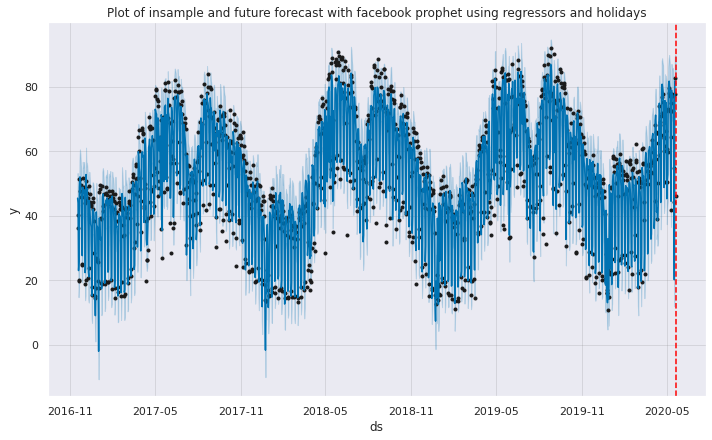

In [ ]:
#plot the predicted data
prophet_reg_model.plot(prophet_reg_pred)
plt.title('Plot of insample and future forecast with facebook prophet using regressors and holidays')
plt.axvline(df_forecast_data['ds'].max(), linestyle = '--', color = 'red')
plt.show();